# Load & Analyze — Siamese (Complete)

In [1]:
# === CONFIG ===
from pathlib import Path
DEVICE = "cuda" if __import__("torch").cuda.is_available() else "cpu"
CKPT_PATH = Path("checkpoints/siamese_mamba_best_10.pt")   # <-- change to your .pt path
DATA_ROOT = Path("cedar_dataset")                   # optional helper root
REQUESTED_BACKBONE = "mambaout_tiny.in1k"


# Manual pairs: (path_img1, path_img2, label) with 1=same/authentic, 0=forged
PAIRS = [
     (DATA_ROOT/'full_org'/'original_1_1.png', DATA_ROOT/'full_org'/'original_5_1.png', 1),
     (DATA_ROOT/'full_org'/'original_1_1.png', DATA_ROOT/'full_forg'/'forgeries_5_1.png', 0),
]
print('DEVICE:', DEVICE)
print('CKPT_PATH:', CKPT_PATH.resolve())


DEVICE: cuda
CKPT_PATH: C:\Users\megel\Documents\signature-mamba\checkpoints\siamese_mamba_best_10.pt


In [2]:
# MODEL
import torch.nn as nn
import torch.nn.functional as F
import torch

try:
    import timm
    HAVE_TIMM = True
except Exception:
    HAVE_TIMM = False

try:
    import torchvision.models as tvm
    HAVE_TV = True
except Exception:
    HAVE_TV = False

def pick_backbone_name(requested: str) -> str:
    if HAVE_TIMM:
        avail = set(timm.list_models("*"))
        if requested in avail:
            return requested
        base = requested.replace(".in1k", "")
        if base in avail:
            print(f"[BACKBONE] Using closest: {base}")
            return base
        m = [m for m in avail if "mamba" in m.lower()]
        if m:
            pref = [x for x in m if ("tiny" in x.lower() or "224" in x.lower())]
            chosen = pref[0] if pref else m[0]
            print(f"[BACKBONE] Using closest: {chosen}")
            return chosen
    if HAVE_TV:
        print("[BACKBONE] Falling back to torchvision resnet18")
        return "tv-resnet18"
    print("[BACKBONE] Falling back to tiny-cnn")
    return "tiny-cnn"

def _ensure_vec(z: torch.Tensor) -> torch.Tensor:
    if z.ndim == 4:   # (B,C,H,W)
        z = z.mean(dim=(2,3))
    elif z.ndim == 3: # (B,L,C)
        z = z.mean(dim=1)
    elif z.ndim == 2:
        pass
    else:
        z = z.view(z.size(0), -1)
    return z

class VisionBackbone(nn.Module):
    def __init__(self, name: str):
        super().__init__()
        self.name = name
        if HAVE_TIMM and not name.startswith("tv-") and name != "tiny-cnn":
            self.encoder = timm.create_model(name, pretrained=True, num_classes=0, global_pool='avg')
            probe = torch.zeros(1,3,224,224)
            with torch.no_grad():
                self.encoder.eval()
                try:
                    out = self.encoder(probe)
                except Exception:
                    feats = self.encoder.forward_features(probe)  # type: ignore[attr-defined]
                    if isinstance(feats, (list,tuple)): feats = feats[-1]
                    out = _ensure_vec(feats)
                out = _ensure_vec(out)
            self.out_dim = int(out.shape[-1])
        elif name == "tv-resnet18" and HAVE_TV:
            m = tvm.resnet18(weights=tvm.ResNet18_Weights.DEFAULT)
            m.fc = nn.Identity()
            self.encoder = m
            self.out_dim = 512
        else:
            self.encoder = nn.Sequential(
                nn.Conv2d(3, 32, 3, 2, 1), nn.ReLU(),
                nn.Conv2d(32, 64, 3, 2, 1), nn.ReLU(),
                nn.Conv2d(64, 128,3, 2, 1), nn.ReLU(),
                nn.AdaptiveAvgPool2d(1),
                nn.Flatten()
            )
            self.out_dim = 128
        print(f"[VisionBackbone] {self.name} -> out_dim={self.out_dim}")

    def forward(self, x):
        z = self.encoder(x)
        return _ensure_vec(z)

class SiameseNet(nn.Module):
    def __init__(self, backbone_name: str, proj_dim: int = 512):
        super().__init__()
        self.backbone = VisionBackbone(backbone_name)
        in_dim = self.backbone.out_dim
        self.head = nn.Sequential(
            nn.Linear(in_dim, proj_dim),
            nn.BatchNorm1d(proj_dim),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.10),
            nn.Linear(proj_dim, proj_dim),
        )

    def embed(self, x):
        z = self.backbone(x)
        z = self.head(z)
        return F.normalize(z, dim=-1)

    def forward(self, x1, x2):
        e1 = self.embed(x1)
        e2 = self.embed(x2)
        d  = torch.norm(e1 - e2, p=2, dim=-1, keepdim=True)
        return d, e1, e2

class ContrastiveLoss(nn.Module):
    def __init__(self, margin: float = 1.0):
        super().__init__()
        self.m = margin
    def forward(self, dist, y):
        pos = y * (dist**2)
        neg = (1-y) * torch.clamp(self.m - dist, min=0.0)**2
        return (pos + neg).mean()

BACKBONE = pick_backbone_name(REQUESTED_BACKBONE)
print("BACKBONE:", BACKBONE)


[BACKBONE] Using closest: mambaout_tiny
BACKBONE: mambaout_tiny


In [3]:
# === LOAD CHECKPOINT ===
import torch
assert CKPT_PATH.exists(), f"Checkpoint not found: {CKPT_PATH}"
state = torch.load(CKPT_PATH, map_location=DEVICE)
backbone_name = state.get("backbone", "mambaout_tiny.in1k")
size          = int(state.get("size", 224))
saved_th      = float(state.get("threshold", 0.5))

model = SiameseNet(backbone_name).to(DEVICE).eval()
model.load_state_dict(state["model"])
print(f"Loaded  backbone={backbone_name} | size={size} | saved_th={saved_th:.4f} | device={DEVICE}")


[VisionBackbone] mambaout_tiny -> out_dim=2304
Loaded  backbone=mambaout_tiny | size=224 | saved_th=0.2824 | device=cuda


In [4]:
# === HELPERS ===
import numpy as np, torch
from PIL import Image
import torchvision.transforms as T
import matplotlib.pyplot as plt
from sklearn.metrics import (roc_curve, roc_auc_score, accuracy_score, f1_score,
                             confusion_matrix, classification_report, average_precision_score, precision_recall_curve)

def maybe_binarize_and_crop(im):
    if 'binarize_and_crop' in globals():
        return binarize_and_crop(im)
    return im

def preprocess_for_model(im, size):
    im = maybe_binarize_and_crop(im)
    tf = T.Compose([T.Resize((size, size)), T.ToTensor(), T.Normalize(mean=[0.5]*3, std=[0.5]*3)])
    return tf(im)

@torch.no_grad()
def compare_paths(img1_path, img2_path, model, size, threshold=None, device=DEVICE):
    im1 = Image.open(img1_path).convert('RGB')
    im2 = Image.open(img2_path).convert('RGB')
    x1 = preprocess_for_model(im1, size).unsqueeze(0).to(device)
    x2 = preprocess_for_model(im2, size).unsqueeze(0).to(device)
    d, e1, e2 = model(x1, x2)
    dist  = float(d.item())
    score = -dist
    pred  = None
    label = None
    if threshold is not None:
        pred  = int(score >= threshold)
        label = "Authentic/Same (1)" if pred==1 else "Forged/Different (0)"
    return {"distance":dist, "score":score, "pred":pred, "label":label}

def eval_manual_pairs(pairs, model, size, threshold=None):
    scores, labels = [], []
    for p1, p2, y in pairs:
        out = compare_paths(p1, p2, model, size, threshold=None, device=DEVICE)
        scores.append(out["score"]); labels.append(int(y))
    scores = np.array(scores); y_true = np.array(labels).astype(int)
    fpr, tpr, thr = roc_curve(y_true, scores); fnr = 1 - tpr
    idx = int(np.nanargmin(np.abs(fpr - fnr)))
    th_eer = float(thr[idx]); eer = float((fpr[idx] + fnr[idx]) / 2)
    grid = np.quantile(scores, np.linspace(0.01, 0.99, 400))
    best_acc, th_acc = -1.0, None
    for th in grid:
        acc = accuracy_score(y_true, (scores >= th).astype(int))
        if acc > best_acc: best_acc, th_acc = float(acc), float(th)
    def _eval(th):
        pred = (scores >= th).astype(int)
        acc = float(accuracy_score(y_true, pred))
        f1  = float(f1_score(y_true, pred))
        auc = float(roc_auc_score(y_true, scores))
        cm  = confusion_matrix(y_true, pred)
        tn, fp, fn, tp = cm.ravel()
        far = float(fp / (fp + tn + 1e-12)); frr = float(fn / (fn + tp + 1e-12))
        ap  = float(average_precision_score(y_true, scores))
        return {"th":float(th), "acc":acc, "f1":f1, "auc":auc, "far":far, "frr":frr, "cm":cm, "ap":ap}
    return scores, y_true, th_eer, eer, th_acc, best_acc, _eval(saved_th), _eval(th_eer), _eval(th_acc)


In [5]:
# === EVALUATE YOUR MANUAL PAIRS (FIXED) ===
assert len(PAIRS) > 0, "Fill PAIRS in the CONFIG cell."

# Run evaluation; returns rich metrics (AUC, FAR/FRR, AP) and key thresholds
scores, y_true, th_eer, eer, th_acc, best_acc, res_saved, res_eer, res_acc = eval_manual_pairs(
    PAIRS, model, size, threshold=None
)

def _print_line(name, r):
    err = 1.0 - float(r["acc"])
    print(f"  {name:<7} th={r['th']:.4f} | acc={r['acc']:.4f} | err={err:.4f} | auc={r['auc']:.4f} | FAR={r['far']:.4f} | FRR={r['frr']:.4f} | AP={r['ap']:.4f}")

print(f"[MANUAL] N={len(y_true)} pairs | EER={eer:.4f} at th={th_eer:.4f} | ACC*={best_acc:.4f} at th={th_acc:.4f}")
_print_line("saved", res_saved)
_print_line("EER",   res_eer)
_print_line("ACC",   res_acc)


[MANUAL] N=2 pairs | EER=1.0000 at th=-1.1233 | ACC*=0.0000 at th=-1.2325
  saved   th=0.2824 | acc=0.5000 | err=0.5000 | auc=0.0000 | FAR=0.0000 | FRR=1.0000 | AP=0.5000
  EER     th=-1.1233 | acc=0.0000 | err=1.0000 | auc=0.0000 | FAR=1.0000 | FRR=1.0000 | AP=0.5000
  ACC     th=-1.2325 | acc=0.0000 | err=1.0000 | auc=0.0000 | FAR=1.0000 | FRR=1.0000 | AP=0.5000


In [6]:
# === SUMMARY TABLE (AUC & ERR included) ===
import pandas as pd

def _row(name, r):
    return {
        "name": name,
        "threshold": float(r["th"]),
        "accuracy": float(r["acc"]),
        "err": float(1.0 - float(r["acc"])),
        "auc": float(r["auc"]),
        "far": float(r["far"]),
        "frr": float(r["frr"]),
        "average_precision": float(r["ap"]),
        "tp": int(r["cm"][1,1]),
        "tn": int(r["cm"][0,0]),
        "fp": int(r["cm"][0,1]),
        "fn": int(r["cm"][1,0]),
    }

summary_df = pd.DataFrame([
    _row("saved",  res_saved),
    _row("eer_opt", res_eer),
    _row("acc_opt", res_acc),
])

try:
    from caas_jupyter_tools import display_dataframe_to_user
    display_dataframe_to_user("Evaluation summary (AUC & ERR)", summary_df)
except Exception:
    pass

out_csv = "/mnt/data/eval_summary.csv"
summary_df.to_csv(out_csv, index=False)
print("Saved summary to:", out_csv)


Saved summary to: /mnt/data/eval_summary.csv


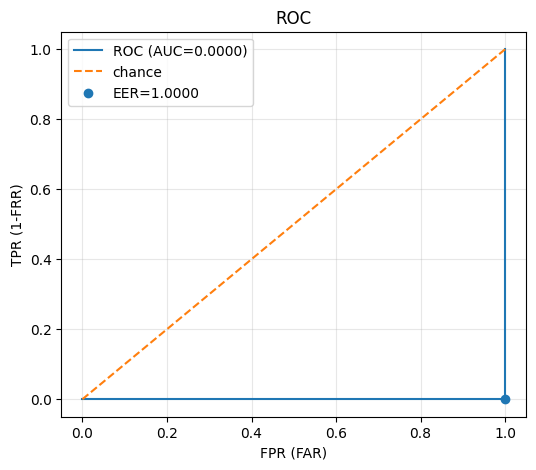

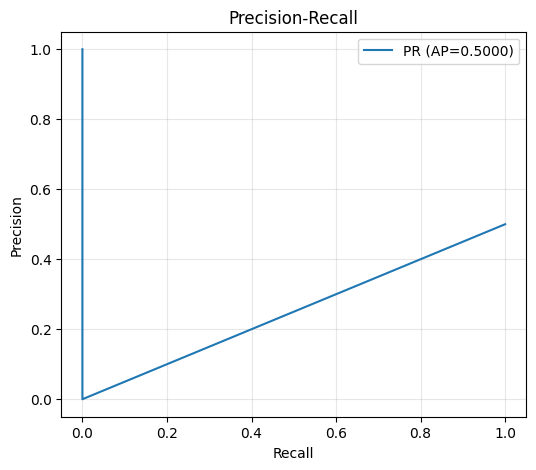

In [7]:
# === PLOTS: ROC & PR, with AUC and EER annotations ===
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, average_precision_score

y = np.array(y_true)
s = np.array(scores)

# ROC
fpr, tpr, _ = roc_curve(y, s)
auc = roc_auc_score(y, s)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"ROC (AUC={auc:.4f})")
plt.plot([0,1],[0,1], '--', label="chance")
plt.scatter([eer],[1-eer], marker='o', label=f"EER={eer:.4f}", zorder=5)
plt.xlabel("FPR (FAR)")
plt.ylabel("TPR (1-FRR)")
plt.title("ROC")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# PR
prec, rec, _ = precision_recall_curve(y, s)
ap = average_precision_score(y, s)
plt.figure(figsize=(6,5))
plt.plot(rec, prec, label=f"PR (AP={ap:.4f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


In [ ]:
# === SALIENCY (Image2-focused by default; Image1 overlays are opt-in) ===
import torch, torch.nn.functional as F
import numpy as np
from pathlib import Path
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import torchvision.transforms as T

def _maybe_binarize_and_crop(im):
    # If your notebook defined binarize_and_crop earlier, use it.
    if 'binarize_and_crop' in globals() and callable(binarize_and_crop):
        try:
            return binarize_and_crop(im)
        except Exception:
            pass
    return im

def _prep_for_model(im_pil, size, device):
    im_pil = _maybe_binarize_and_crop(im_pil)
    disp   = im_pil.copy()
    tf = T.Compose([
        T.Resize((size, size)),
        T.ToTensor(),
    ])
    x = tf(im_pil).unsqueeze(0).to(device)
    return x, disp

@torch.no_grad()
def _pair_distance(model, x1, x2):
    # Assumes your Siamese model returns (dist, e1, e2)
    d, _, _ = model(x1, x2)
    return float(d.item())

def _occlusion_map(model, x_target, x_other, win, stride):
    """
    Slide a window on x_target; for each occluded region, measure how much the
    pairwise distance changes. Larger change => more important region.
    Returns a HxW heatmap (in *model* resolution).
    """
    B, C, H, W = x_target.shape
    base = _pair_distance(model, x_target, x_other)

    # Precompute a 'neutral' patch (mean per-channel)
    mean_patch = x_target.mean(dim=(2,3), keepdim=True)  # [B,C,1,1]

    heat = torch.zeros((H, W), device=x_target.device)

    for y in range(0, H - win + 1, stride):
        for x in range(0, W - win + 1, stride):
            xt = x_target.clone()
            xt[:, :, y:y+win, x:x+win] = mean_patch  # occlude
            dist = _pair_distance(model, xt, x_other)
            delta = abs(dist - base)
            heat[y:y+win, x:x+win] += delta

    # Normalize to [0,1]
    if float(heat.max()) > 1e-8:
        heat = heat / heat.max()
    return heat

def _top_window(hm, win):
    """Find the max-sum window (y0,x0,y1,x1) in the heatmap (model-res coords)."""
    H, W = hm.shape
    best_sum = -1.0
    best_box = (0,0,win,win)
    step = max(1, win // 4)
    for y in range(0, H - win + 1, step):
        for x in range(0, W - win + 1, step):
            s = hm[y:y+win, x:x+win].sum()
            if s > best_sum:
                best_sum = s
                best_box = (x, y, x+win, y+win)
    return best_box  # (x0,y0,x1,y1)

def _scale_box(box, sx, sy):
    x0, y0, x1, y1 = box
    return (int(x0*sx), int(y0*sy), int(x1*sx), int(y1*sy))

def _clip_box(box, w, h):
    x0, y0, x1, y1 = box
    x0 = max(0, min(x0, w-1)); x1 = max(0, min(x1, w))
    y0 = max(0, min(y0, h-1)); y1 = max(0, min(y1, h))
    if x1 <= x0: x1 = min(w, x0+1)
    if y1 <= y0: y1 = min(h, y0+1)
    return (x0, y0, x1, y1)

def saliency_zoom_view_consistent(
    p1, p2, model, size,
    threshold, threshold_type="distance",
    device="cpu", win_ratio=0.28, zoom=2.5,
    show_original_panel=True, heat_alpha=0.45, stride_frac=0.12,
    # NEW toggles (default = your current behavior):
    image1_heatmap=False,
    image1_box=False,
):
    """
    DISPLAY RULES (default = clarity-first):
    - Image 1: no heatmap, no box (unless toggled on)
    - Image 2: heatmap + box (always)
    - Zoom uses Image 2 bbox for BOTH images (same region), para apples-to-apples
    - Panels are same size
    """
    model.eval()

    # Load originals
    p1 = Path(p1); p2 = Path(p2)
    im1_raw = Image.open(p1).convert("RGB")
    im2_raw = Image.open(p2).convert("RGB")
    w1, h1 = im1_raw.size; w2, h2 = im2_raw.size

    # Prep for model (and keep display copies)
    x1, im1_disp = _prep_for_model(im1_raw, size, device)
    x2, im2_disp = _prep_for_model(im2_raw, size, device)

    # Distance / score / pred
    base_dist = _pair_distance(model, x1, x2)
    if threshold_type == "distance":
        score = base_dist
        pred  = int(score >= float(threshold))
    else:
        # e.g., for similarity-based scoring
        score = 1.0 - base_dist
        pred  = int(score >= float(threshold))
    pred_text = "forged" if pred == 1 else "authentic"

    # Occlusion params
    win = max(8, int(size * float(win_ratio)))
    stride = max(1, int(win * float(stride_frac)))

    # Image 2 heatmap (ALWAYS)
    hm2 = _occlusion_map(model, x2, x1, win=win, stride=stride).cpu().numpy()
    b2 = _top_window(hm2, win)  # (x0,y0,x1,y1) in model-res

    # Image 1 heatmap/box only if requested
    hm1 = None; b1 = None
    if image1_heatmap or image1_box:
        hm1 = _occlusion_map(model, x1, x2, win=win, stride=stride).cpu().numpy()
        b1 = _top_window(hm1, win)

    # Map chosen window (Image 2) back to originals for zoom/box
    sx1, sy1 = w1/size, h1/size
    sx2, sy2 = w2/size, h2/size

    b2_img = _scale_box(b2, sx2, sy2)
    b2_img = _clip_box(b2_img, w2, h2)

    # Optional Image 1 box (if requested)
    b1_img = _scale_box(b1, sx1, sy1) if b1 is not None else None
    if b1_img is not None:
        b1_img = _clip_box(b1_img, w1, h1)

    # For saliency boxes row:
    im1_box = im1_raw.copy()
    if image1_box and b1_img is not None:
        ImageDraw.Draw(im1_box).rectangle(b1_img, outline=(255,0,0), width=3)

    im2_box = im2_raw.copy()
    ImageDraw.Draw(im2_box).rectangle(b2_img, outline=(255,0,0), width=3)

    # Zoom crops — SAME REGION (from Image 2 bbox) on BOTH images
    # Map Image 2 bbox onto Image 1 coords using model-res box (b2)
    b1_from_b2_img = _scale_box(b2, sx1, sy1)
    b1_from_b2_img = _clip_box(b1_from_b2_img, w1, h1)

    crop1 = im1_raw.crop(b1_from_b2_img)
    crop2 = im2_raw.crop(b2_img)
    zW = max(1, int((b2_img[2]-b2_img[0]) * zoom))
    zH = max(1, int((b2_img[3]-b2_img[1]) * zoom))
    crop1 = crop1.resize((zW, zH), Image.BICUBIC)
    crop2 = crop2.resize((zW, zH), Image.BICUBIC)

    # Prepare display sizes
    # Heatmaps are in model-res; align base images to that res for overlay
    Hm2, Wm2 = hm2.shape
    im2_hm_base = im2_disp.resize((Wm2, Hm2))
    if hm1 is not None:
        Hm1, Wm1 = hm1.shape
        im1_hm_base = im1_disp.resize((Wm1, Hm1))
    else:
        Hm1, Wm1 = size, size
        im1_hm_base = im1_disp.resize((Wm1, Hm1))

    # ---- FIGURE LAYOUT ----
    plt.figure(figsize=(12, 16))

    # Row 1: Originals (no boxes)
    ax1 = plt.subplot(4,2,1)
    if show_original_panel: ax1.imshow(im1_raw)
    ax1.set_title(f"Image 1 — {p1.name}"); ax1.axis('off')

    ax2 = plt.subplot(4,2,2)
    if show_original_panel: ax2.imshow(im2_raw)
    ax2.set_title(f"Image 2 — {p2.name}"); ax2.axis('off')

    # Row 2: Heatmaps
    ax3 = plt.subplot(4,2,3)
    ax3.imshow(im1_hm_base)
    if image1_heatmap and hm1 is not None:
        ax3.imshow(hm1, alpha=heat_alpha, cmap='jet')
        if image1_box and b1 is not None:
            x0,y0,x1b,y1b = b1
            ax3.add_patch(Rectangle((x0,y0), x1b-x0, y1b-y0, fill=False, edgecolor='yellow', linewidth=2))
        ax3.set_title("Image 1 — Heatmap" + (" + Box" if image1_box else ""))
    else:
        ax3.set_title("Image 1 — Heatmap (none)")
    ax3.axis('off')

    ax4 = plt.subplot(4,2,4)
    ax4.imshow(im2_hm_base)
    ax4.imshow(hm2, alpha=heat_alpha, cmap='jet')
    x0,y0,x1b,y1b = b2
    ax4.add_patch(Rectangle((x0,y0), x1b-x0, y1b-y0, fill=False, edgecolor='yellow', linewidth=2))
    ax4.set_title("Image 2 — Heatmap"); ax4.axis('off')

    # Row 3: Saliency / Boxes
    ax5 = plt.subplot(4,2,5)
    ax5.imshow(im1_box)
    ax5.set_title("Image 1 — Saliency " + ("(box)" if (image1_box and b1_img is not None) else "(none)"))
    ax5.axis('off')

    ax6 = plt.subplot(4,2,6)
    ax6.imshow(im2_box)
    ax6.set_title("Image 2 — Saliency (box)")
    ax6.axis('off')

    # Row 4: Zoom (SAME region from Image 2 bbox)
    ax7 = plt.subplot(4,2,7)
    ax7.imshow(crop1)
    ax7.set_title("Image 1 — ZOOM (Image2 region)"); ax7.axis('off')

    ax8 = plt.subplot(4,2,8)
    ax8.imshow(crop2)
    ax8.set_title("Image 2 — ZOOM"); ax8.axis('off')

    title = f"dist={base_dist:.4f} | thresh({threshold_type})={float(threshold):.4f} | pred={pred} ({pred_text})"
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

    # Results table
    try:
        import pandas as pd
        df = pd.DataFrame([{
            "image1": p1.name,
            "image2": p2.name,
            "distance": round(float(score), 6),
            "threshold": float(threshold),
            "pred": int(pred),
            "pred_text": pred_text
        }])
        display(df)
    except Exception:
        print(f"Result | image1={p1.name} | image2={p2.name} | distance={score:.6f} | threshold={float(threshold):.6f} | pred={pred} ({pred_text})")

    print("Done.")


In [ ]:
# === PICK IMAGES FOR SALIENCY  ===
from pathlib import Path

P1 = (DATA_ROOT / "full_org" / "original_4_1.png").resolve()
P2 = (DATA_ROOT / "full_forg" / "forgeries_4_1.png").resolve()

assert P1.exists(), f"Missing: {P1}"
assert P2.exists(), f"Missing: {P2}"
print("P1:", P1)
print("P2:", P2)

# Set threshold kind/value consistent with training (distance for L2)
THRESH_KIND = "distance"
THRESH_VALUE = float(saved_th)
print("THRESH_KIND:", THRESH_KIND, "| THRESH_VALUE:", THRESH_VALUE)


P1: C:\Users\megel\Documents\signature-mamba\cedar_dataset\full_org\original_4_1.png
P2: C:\Users\megel\Documents\signature-mamba\cedar_dataset\full_org\original_50_3.png
THRESH_KIND: distance | THRESH_VALUE: 0.28236353397369385


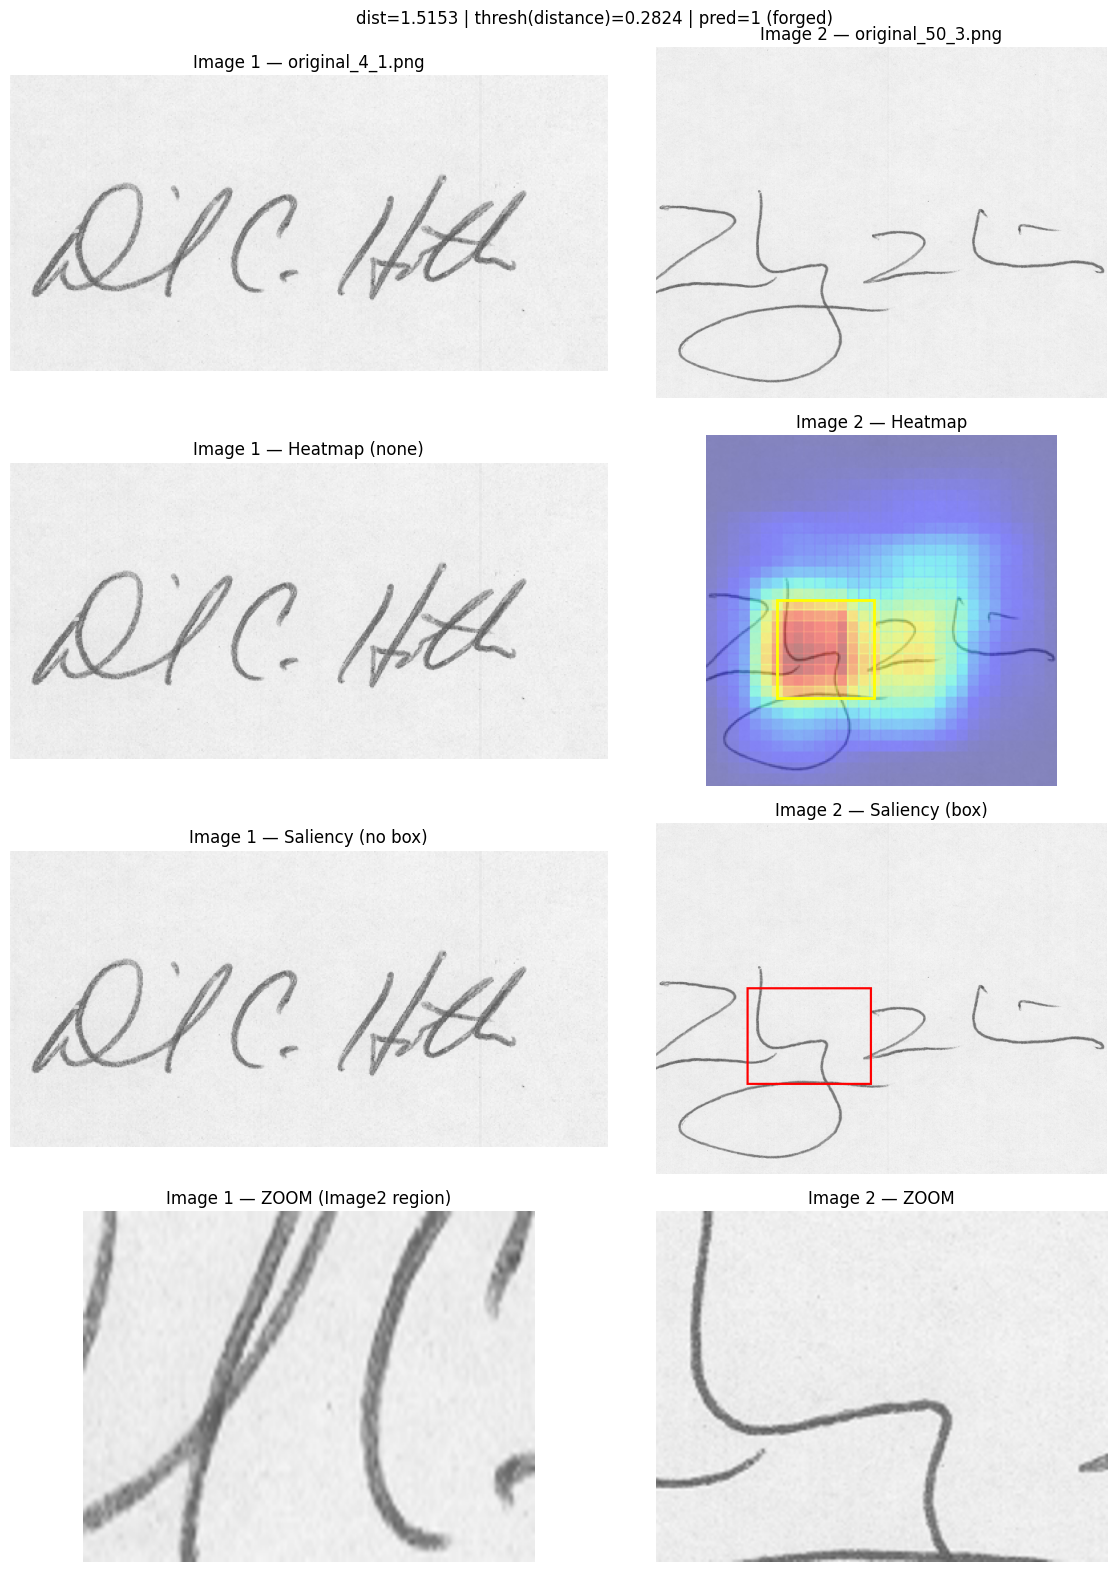

,image1,image2,distance,threshold,pred,pred_text
0,original_4_1.png,original_50_3.png,1.51529,0.282364,1,forged


Done.


In [21]:
# === RUN SALIENCY VIEW ===
saliency_zoom_view_consistent(
    P1, P2,
    model, size,
    threshold=THRESH_VALUE,
    threshold_type=THRESH_KIND,
    device=DEVICE,
    win_ratio=0.28,
    zoom=2.5,
    show_original_panel=True
)
